# **Predicting Cancer Mortality Rates in US Counties**

First, import all necessary packages and dependencies. 

In [14]:
#Imports and Packages

import os
import pandas as pd
from pandas.plotting import scatter_matrix
import csv 
import matplotlib.pyplot as plt
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

Next, we define the dataset paths. The root directory needs to be changed to your active working directory. Make sure both csv files are present in the Data_for_regression folder.  

In [3]:
#Dataset Path Definition 

root_dir = './' #To be defined by you
local_path = 'Data-for-regression/' 
data_dir = root_dir + local_path

training_data_path = data_dir + 'Training_data.csv'
training_targets_path = data_dir + 'Training_data_targets.csv'

The cell below generates histograms based on the 

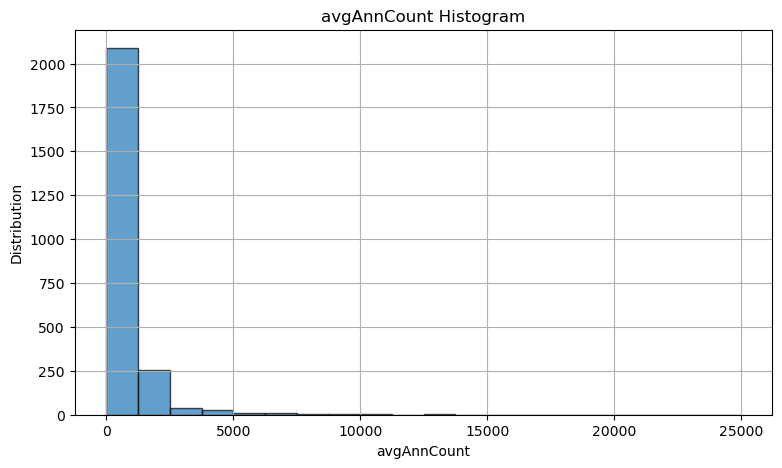

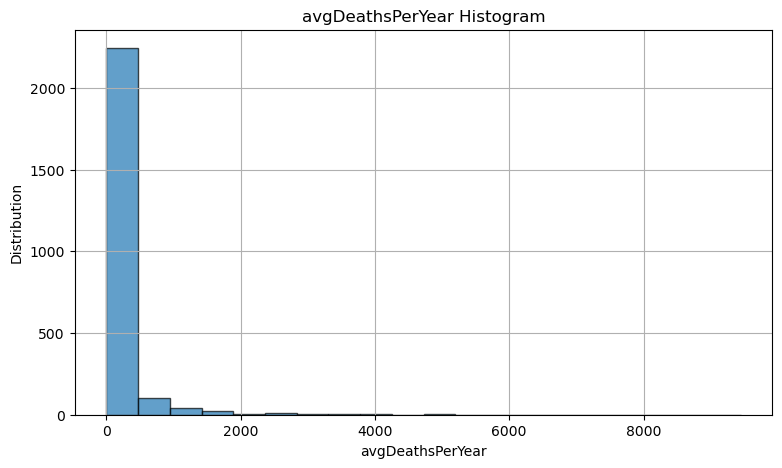

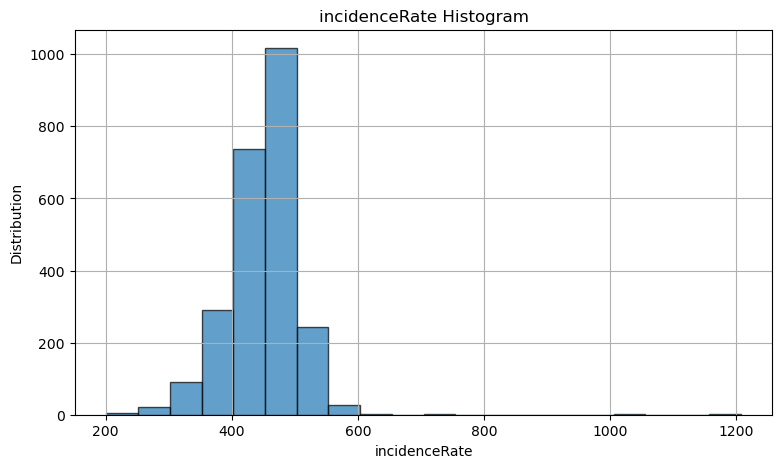

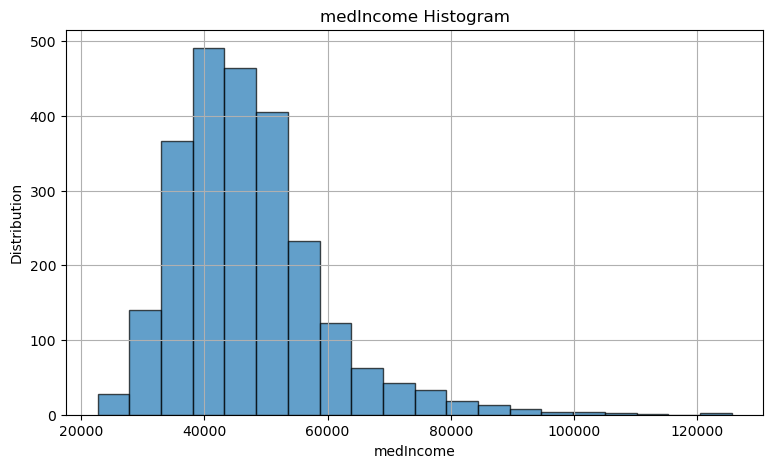

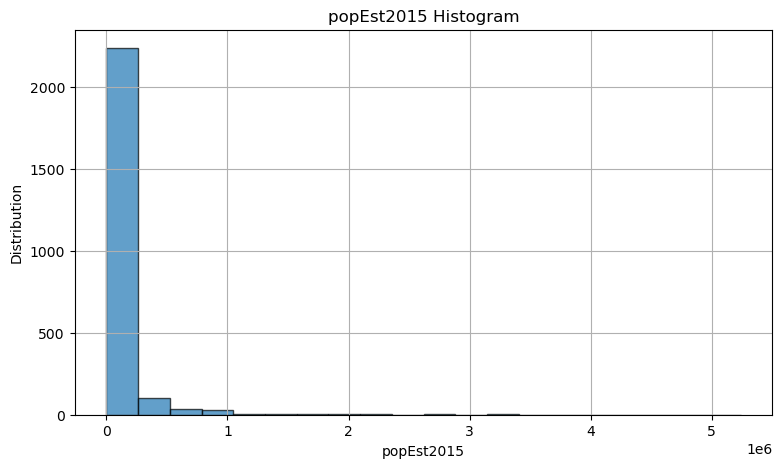

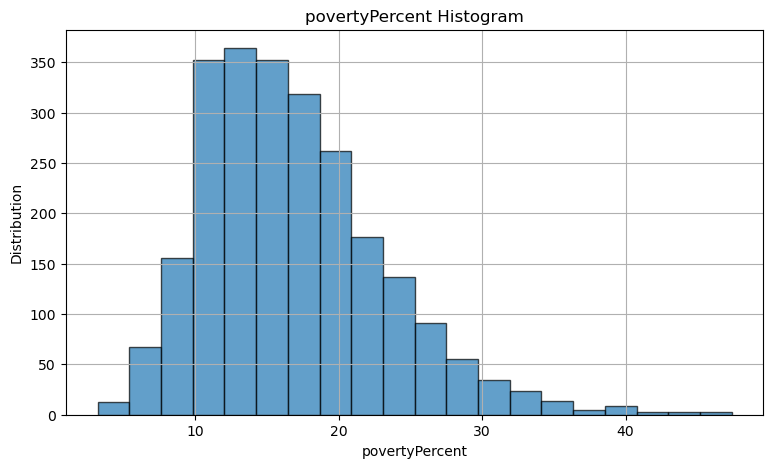

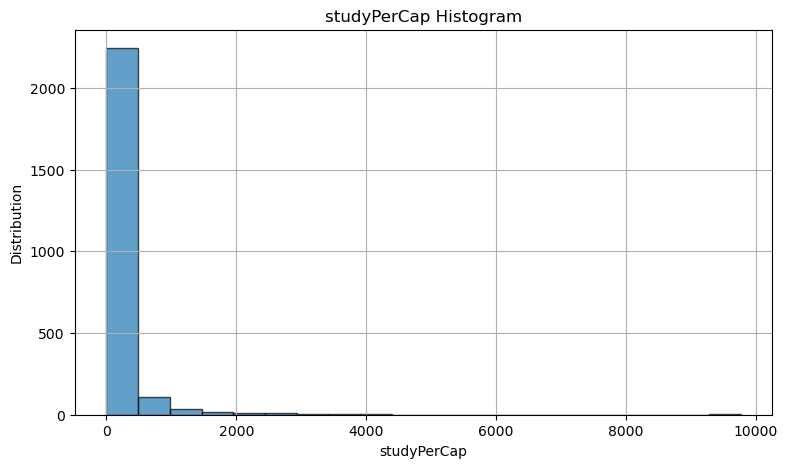

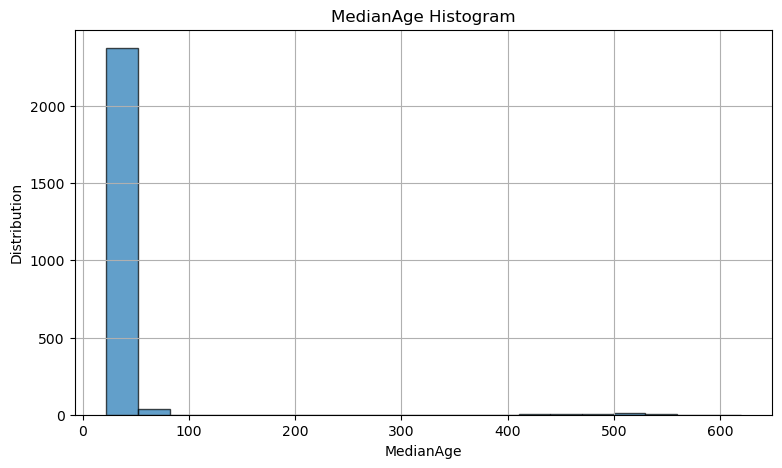

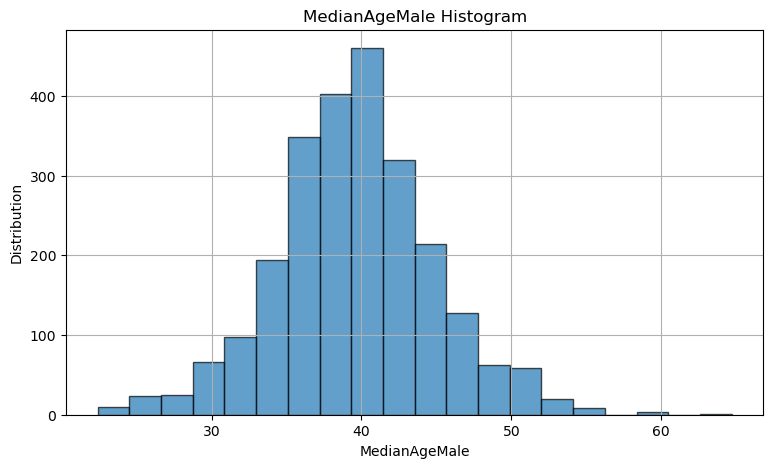

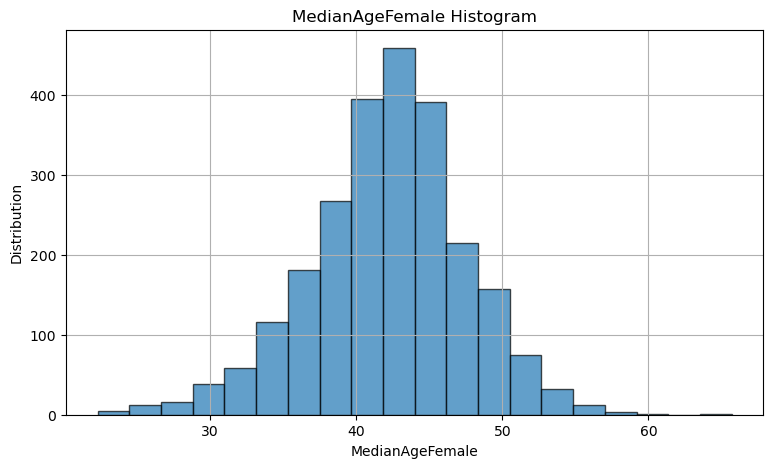

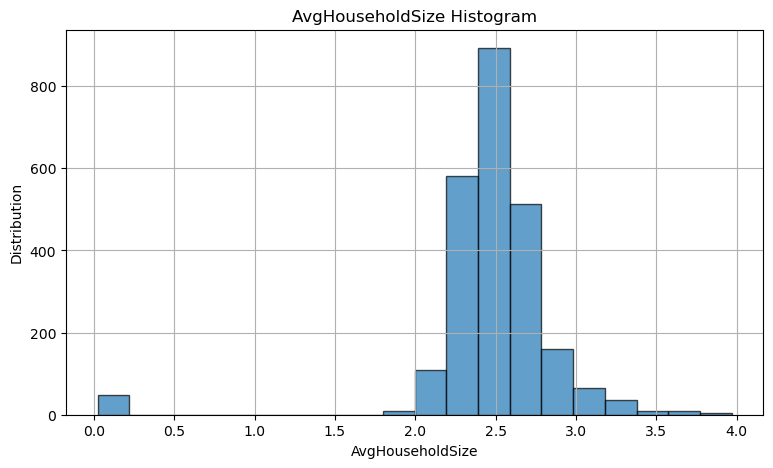

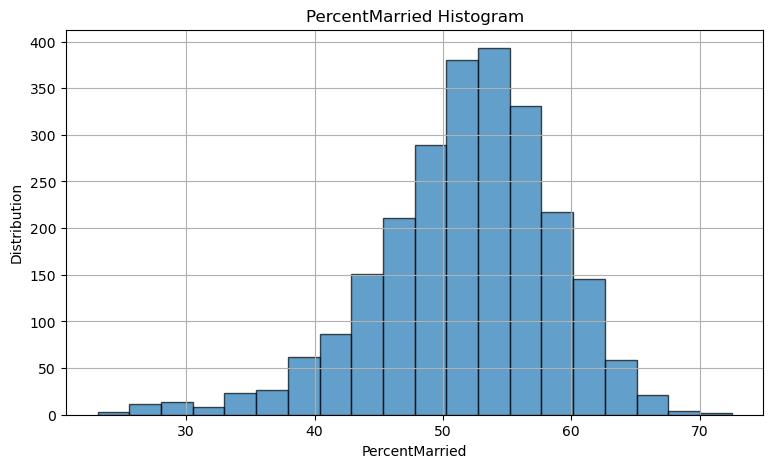

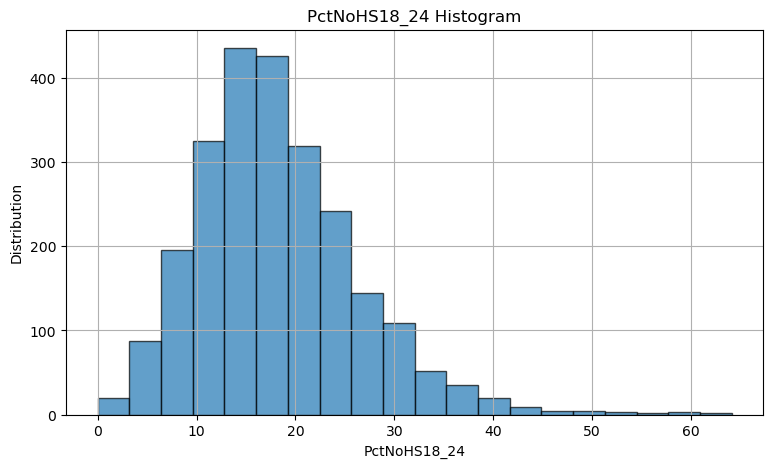

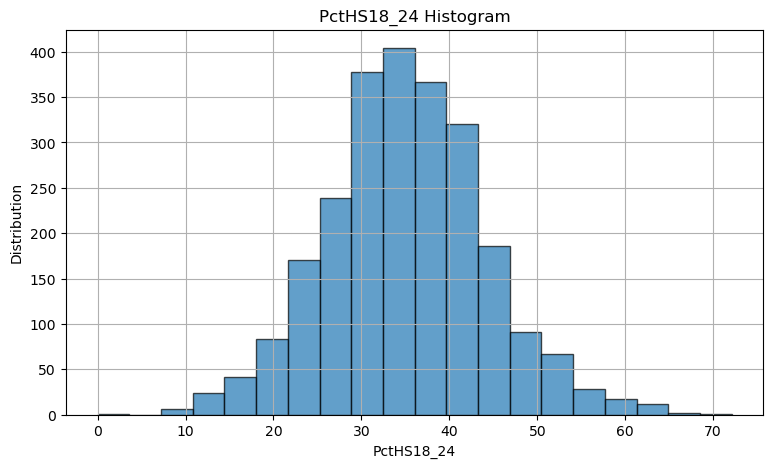

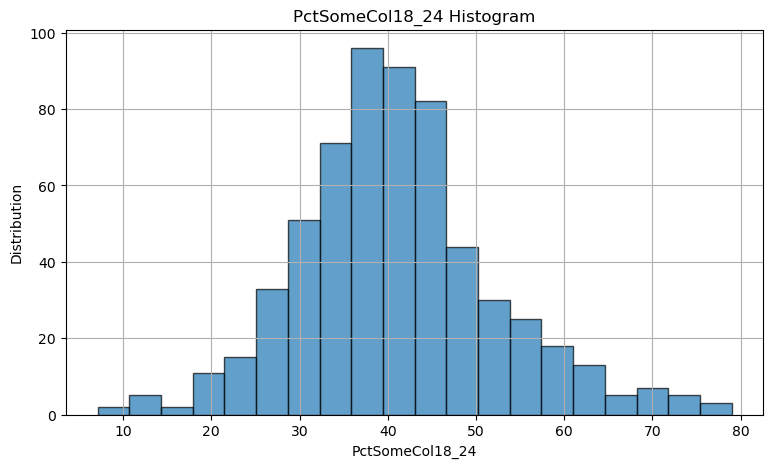

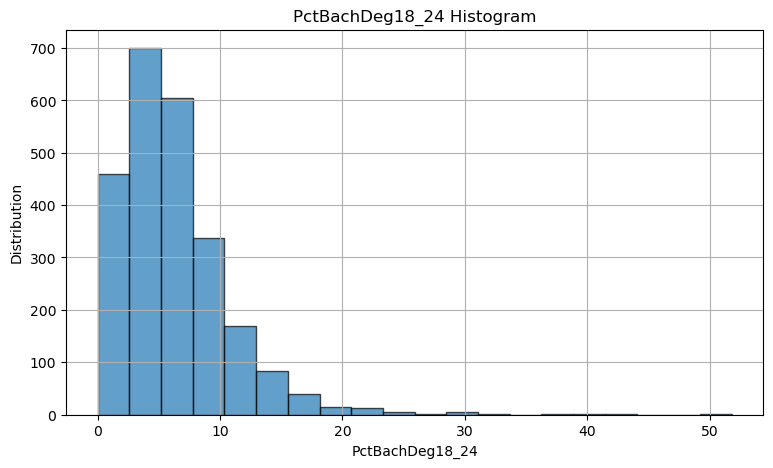

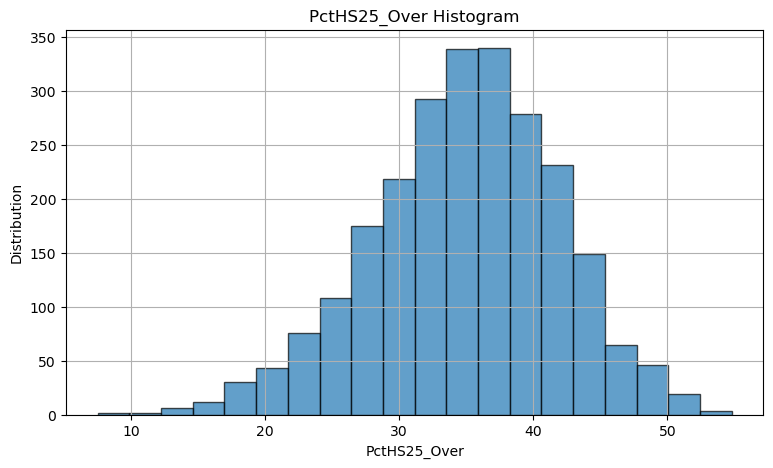

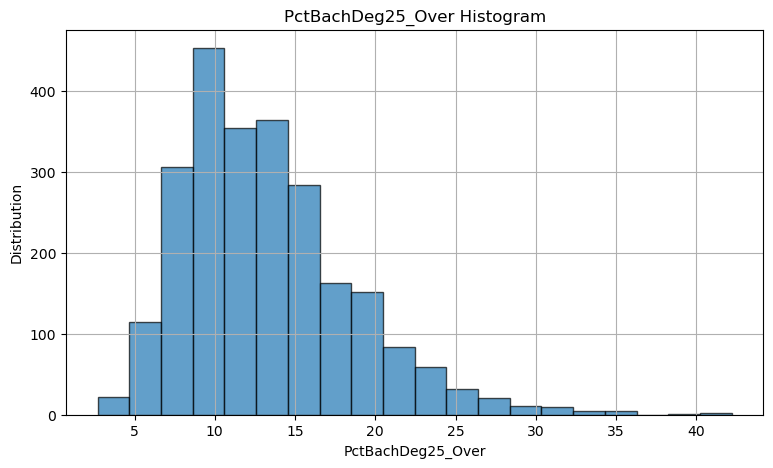

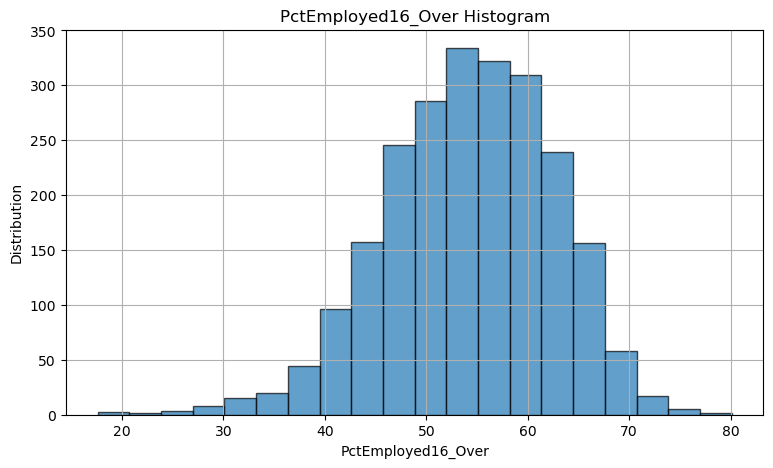

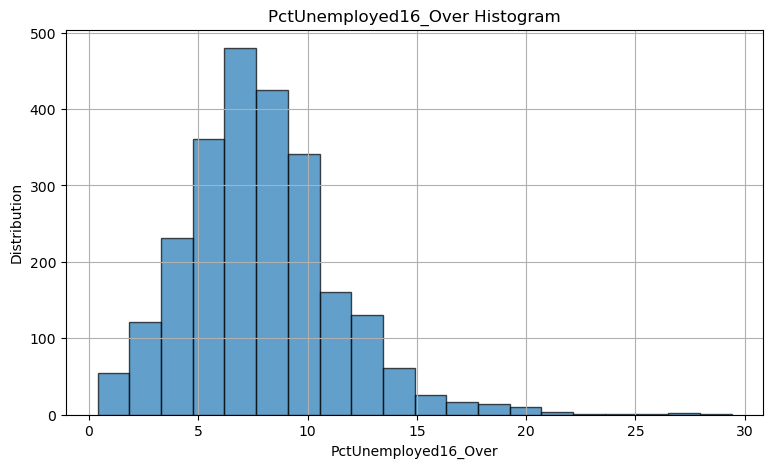

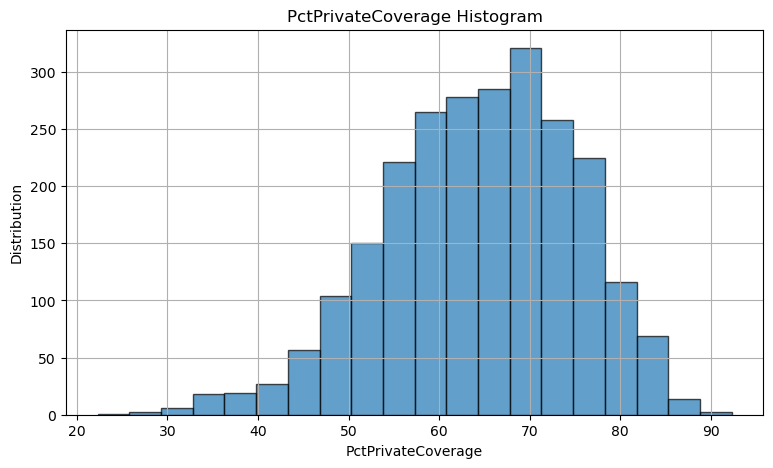

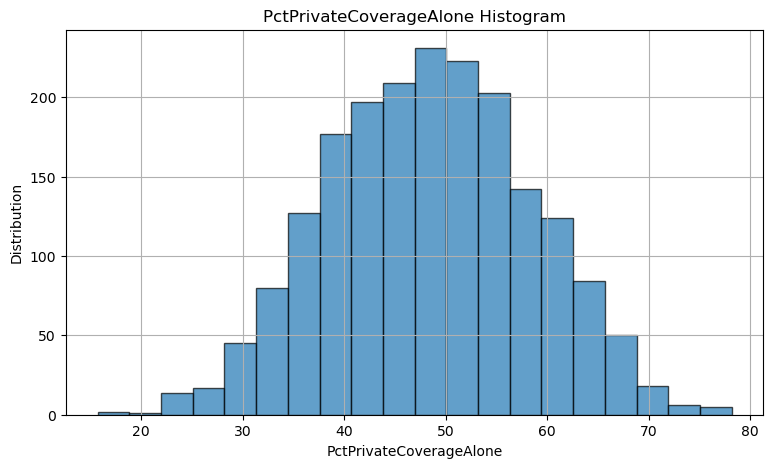

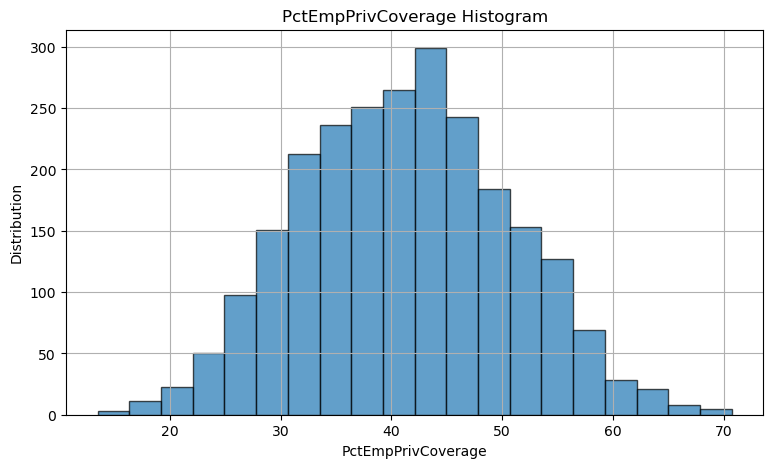

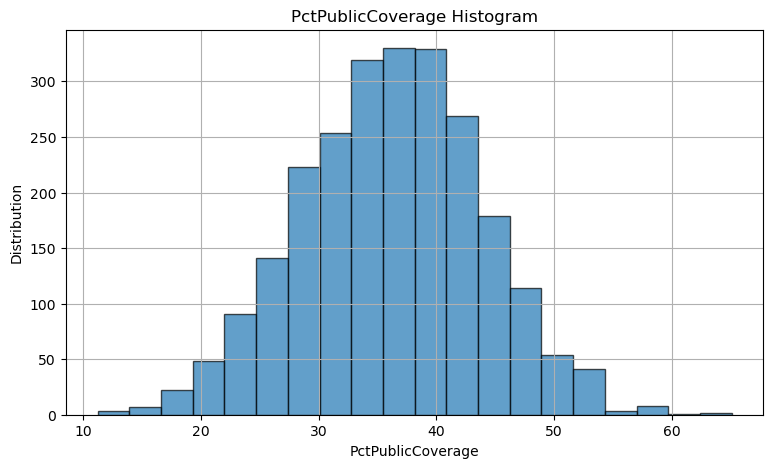

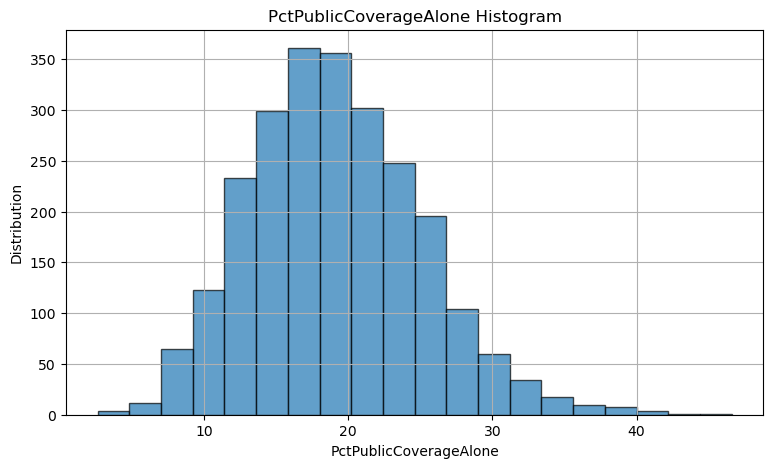

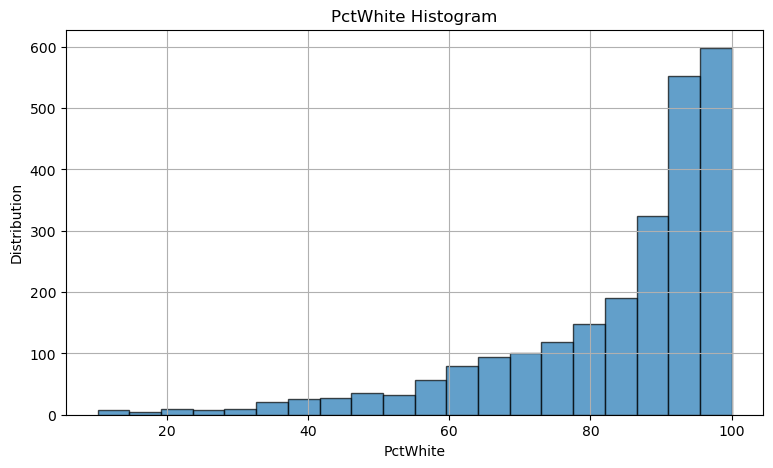

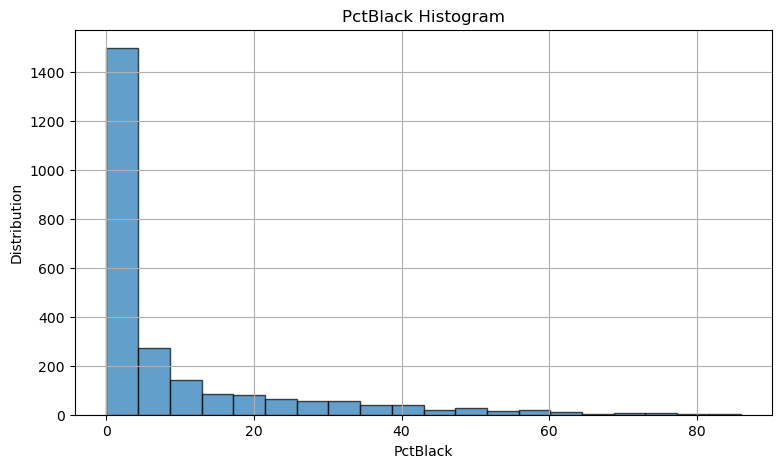

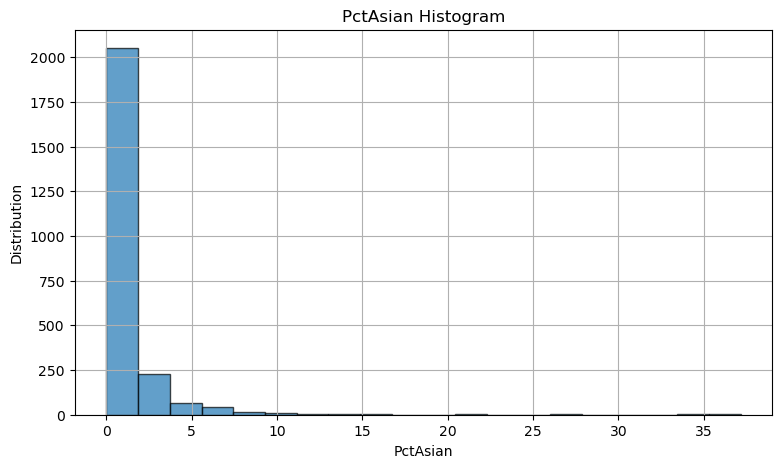

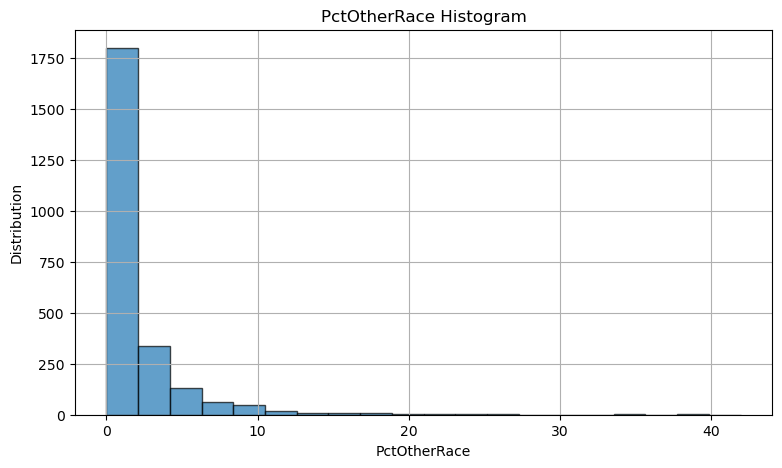

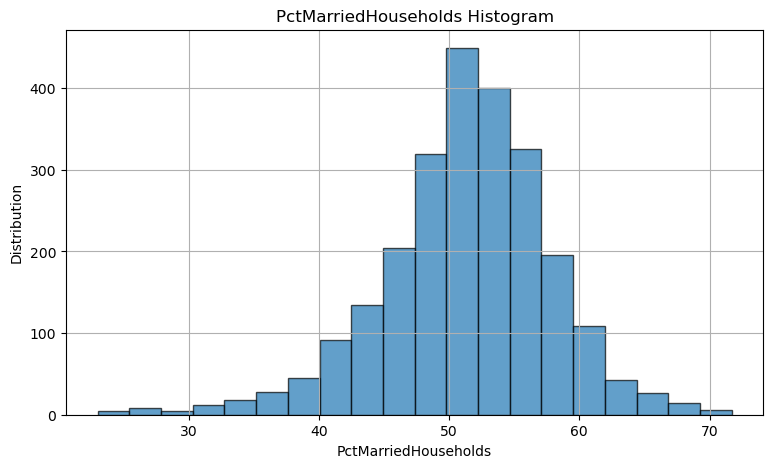

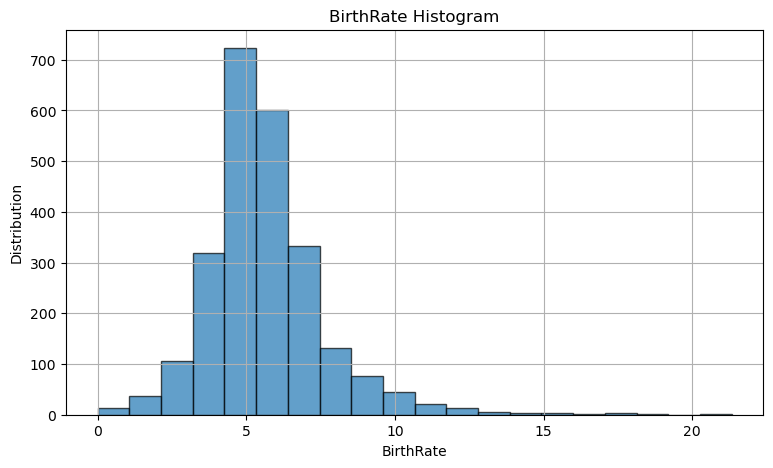

In [4]:
#Generate Histograms To Display Continuous Data Distribution 

output_folder = 'Histogram Images'
os.makedirs(output_folder, exist_ok=True)

training_df = pd.read_csv(training_data_path)

for feature in training_df.columns:
    plt.figure(figsize=(9, 5))
    plt.hist(training_df[feature], bins=20, alpha=0.7, ec="black")
    plt.title(f'{feature} Histogram')
    plt.xlabel(feature)
    plt.ylabel('Distribution')
    plt.grid(True)
    
    image_file_path = os.path.join(output_folder, f'{feature}_histogram.png')
    
    plt.savefig(image_file_path)
    
    plt.show()
    plt.close()

Most of data plotted in the histograms seems normal. However, for the median age there are some plots around the 400 and 500 marks, which are unusual and should be considered outliers. In addition, the household size histogram indicates that there is a plot very close to 0, which can also be deemed to be unusual as no house should be that small.

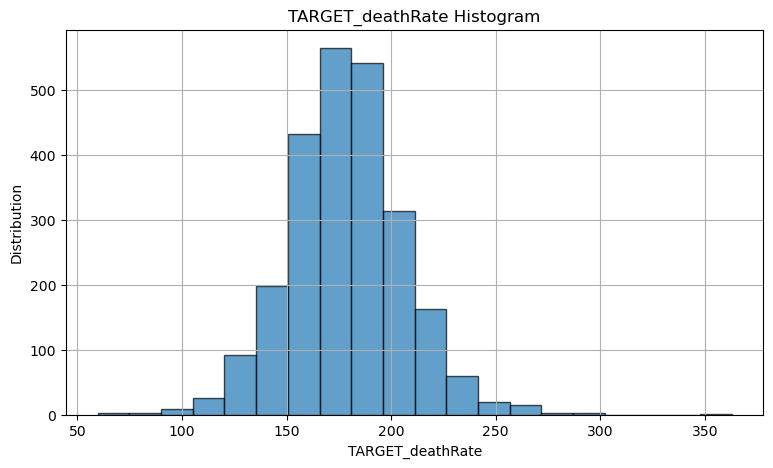

In [5]:
#Target Data Histogram

output_folder = 'Histogram Images'
os.makedirs(output_folder, exist_ok=True)

target_df = pd.read_csv(training_targets_path)

for feature in target_df.columns:

    plt.figure(figsize=(9, 5))
    plt.hist(target_df[feature], bins=20, alpha=0.7, ec="black")
    plt.title(f'{feature} Histogram')
    plt.xlabel(feature)
    plt.ylabel('Distribution')
    plt.grid(True)
    
    image_file_path = os.path.join(output_folder, f'{feature}_histogram.png')
    
    plt.savefig(image_file_path)
    
    plt.show()
    plt.close()

Now calculate the correlation each feature has to the target.

In [6]:
#Calculating Correlations Between Dataframes.

correlations = training_df.corrwith(target_df['TARGET_deathRate'])

sorted_correlations = correlations.abs().sort_values(ascending=False)

print('Correlations of features with the target deathrate:')
print(sorted_correlations)

Correlations of features with the target deathrate:
PctBachDeg25_Over          0.491411
incidenceRate              0.443983
PctPublicCoverageAlone     0.439734
medIncome                  0.416607
povertyPercent             0.413260
PctHS25_Over               0.409915
PctEmployed16_Over         0.400317
PctPublicCoverage          0.391899
PctPrivateCoverage         0.382786
PctUnemployed16_Over       0.362612
PctPrivateCoverageAlone    0.355050
PctMarriedHouseholds       0.290645
PctBachDeg18_24            0.284566
PctHS18_24                 0.266285
PercentMarried             0.266153
PctEmpPrivCoverage         0.259006
PctBlack                   0.236380
PctSomeCol18_24            0.186140
PctOtherRace               0.182602
PctAsian                   0.181948
PctWhite                   0.174521
avgAnnCount                0.150019
popEst2015                 0.130122
avgDeathsPerYear           0.094048
PctNoHS18_24               0.090565
BirthRate                  0.088543
AvgHousehold

Scatter graphs of the 5 most correlated features are displayed for additional visualisation. The normal distributions are shown in the place where the feature is identical to the one it is being compared to. 

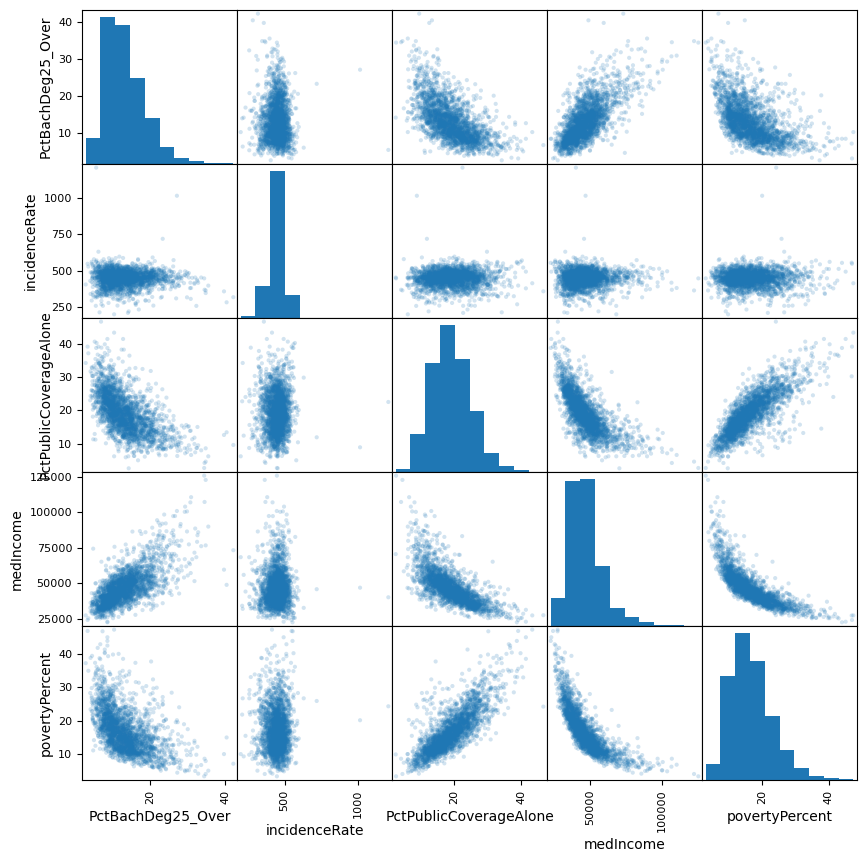

In [7]:
#Scatter Matrix Displaying Top 5 Correlated Features

correlations = training_df.corrwith(target_df['TARGET_deathRate'])

five_features = correlations.abs().sort_values(ascending=False).head(5)

five_features_data = training_df[five_features.index]

scatter_matrix(five_features_data, figsize=(10, 10), alpha=0.2)

image_file_path = os.path.join(output_folder, f'{feature}_scatter.png')
    
plt.savefig(image_file_path)
    
plt.show()

Now, we fit three regression models to the data. The models used are Ordinary least squares (OLS), Lasso and Ridge, which are defined below. First the data must be split into training, validation and testing sets before being pre-processed and 
fed into the pipelines. 

In [8]:
#Split Data Into Training and Testing 

x_train, x_test, y_train, y_test = train_test_split(training_df, target_df, test_size=0.2, random_state=42)

In [9]:
#Pre-Process Data

processor = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])

features = training_df.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', processor, features)
    ])

In [10]:
#OLS Regression Model

ols_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

ols_fit = ols_pipeline.fit(x_train, y_train)

In [11]:
#Lasso Regression Model

lasso_alpha = 0.001

lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=lasso_alpha))
])

lasso_fit = lasso_pipeline.fit(x_train, y_train)

In [12]:
#Ridge Regression Model

ridge_alpha = 0.01

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=ridge_alpha))
])

ridge_fit = ridge_pipeline.fit(x_train, y_train)

Weight regularisation was not applied to OLS as it does not include a regularisation parameter. This is due to the fact that it is a straightforward linear equation solving algorithm.

We now calculate the mean squared error (MSE) of all three models, iteratively.  

In [13]:
#Loop to calculate MSE of the three models

model_fittings = [ols_fit, lasso_fit, ridge_fit]
model_names = ['OLS', 'Lasso', 'Ridge']

for i, model in enumerate(model_fittings):
    
    model_predictions = model.predict(x_test)
    
    MSE = mean_squared_error(y_test, model_predictions)
    R2 = r2_score(y_test, model_predictions)
    
    print(f'{model_names[i]} Regression:')
    print(f'Mean Squared Error: {MSE}')

OLS Regression:
Mean Squared Error: 349.783606454694
Lasso Regression:
Mean Squared Error: 349.78104556798786
Ridge Regression:
Mean Squared Error: 349.7836188427912


OLS received a score of 349.783606454694.

Lasso and Ridge have weight regularisation capabilities, thus I applied it to both, testing various alpha values, ranging from -0.9 to 0.9. Ridge seemed largely unaffected, with very marginal changes, and the same for lasso, but I was able to get the MSE score down from 369.92585581326017 to 349.7810455679878 by using a weight regularisation value of 0.001.

The final model scores are the ones displayed above.

Therefore, the best peforming model is the Lasso model with weight regularisation of 0.001, as it has the lowest MSE score of 349.7810455679878.